# Histopathologic Cancer Detection



# 1. Project Overview
In this project, we work on identifying metastatic cancer in small image patches (96x96 pixels) extracted from larger digital pathology scans. Each image is labeled as 1 (cancer) or 0 (no cancer). The goal is to accurately classify these patches to assist in faster cancer diagnosis.

Dataset summary:
- Each image is a 96x96 color image (RGB).
- Images are stored in `.tif` format.
- Labels are provided separately in a `labels.csv` file.
- Task: Binary image classification (Cancer: 1, Non-cancer: 0).

# 2. EDA

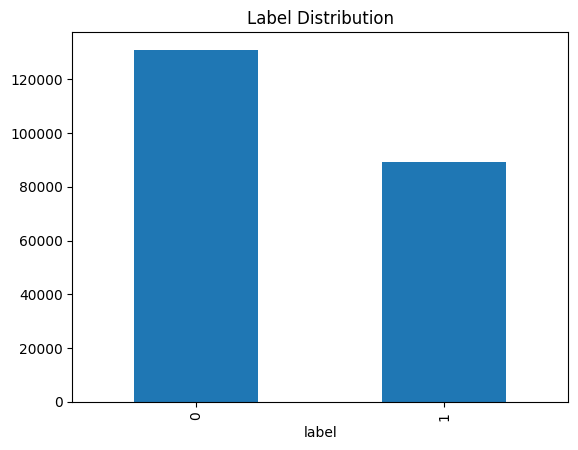

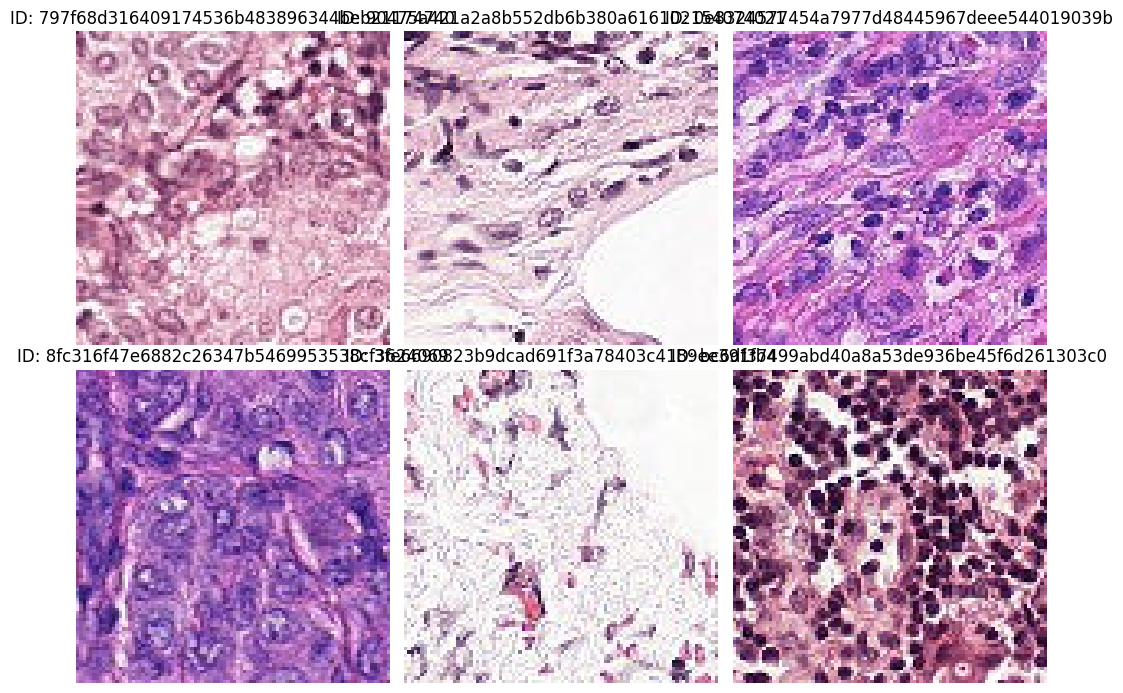

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
import numpy as np

# Load labels
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df['label'].value_counts().plot(kind='bar', title='Label Distribution')
df['label'] = df['label'].astype(str)
plt.show()

# Show a few example images
sample_ids = df.sample(6)['id'].values
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, img_id in zip(axes.flatten(), sample_ids):
    img = Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif')
    ax.imshow(img)
    ax.set_title(f'ID: {img_id}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3. Pre-Processing

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dir = "/kaggle/input/histopathologic-cancer-detection/train"
df["id"] = df["id"].astype(str) + ".tif"
df["path"] = df["id"].apply(lambda x: os.path.join(image_dir, x))

# Parameters
IMG_SIZE = 96
BATCH_SIZE = 64
df = df.sample(frac=0.05, random_state=42).reset_index(drop=True)
# Data Generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='path',
    y_col='label',
    subset='training',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    seed = 42
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='path',
    y_col='label',
    subset='validation',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    seed = 42
)

2025-04-27 20:08:21.208540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745784501.456911      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745784501.527657      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8801 validated image filenames belonging to 2 classes.
Found 2200 validated image filenames belonging to 2 classes.


# 4. Build the baseline CNN Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

baseline_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training the Baseline Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('baseline_model.keras', save_best_only=True)

history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)

# 6.Training the Optimized Model


In [ ]:
from tensorflow.keras.optimizers import RMSprop

optimized_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimized_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint('optimized_model.keras', save_best_only=True)

history_optimized = optimized_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, checkpoint2]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('optimized_model.keras', save_best_only=True)

history_optimized = optimized_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)

# 7. Hyperparameters

In [ ]:
from tensorflow.keras.optimizers import RMSprop, SGD

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint("optimized_model.keras", save_best_only=True)
# Update model with RMSprop
print("Compiling model")
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

print("Training optimized model")
optimized_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint]  
)


# 8. Evaluating the Models

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_baseline.history['accuracy'], label='Baseline Train')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Val')
plt.title('Baseline Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_optimized.history['accuracy'], label='Optimized Train')
plt.plot(history_optimized.history['val_accuracy'], label='Optimized Val')
plt.title('Optimized Accuracy')
plt.legend()

plt.show()

# 9. Results

In [ ]:
import pandas as pd

baseline_final = {
    "Train Accuracy": history_baseline.history['accuracy'][-1],
    "Val Accuracy": history_baseline.history['val_accuracy'][-1]
}

optimized_final = {
    "Train Accuracy": history_optimized.history['accuracy'][-1],
    "Val Accuracy": history_optimized.history['val_accuracy'][-1]
}

results = pd.DataFrame([baseline_final, optimized_final], index=['Baseline (SGD)', 'Optimized (RMSprop)'])
display(results)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract final epoch results
baseline_train_acc = history_baseline.history['accuracy'][-1]
baseline_val_acc = history_baseline.history['val_accuracy'][-1]
optimized_train_acc = history_optimized.history['accuracy'][-1]
optimized_val_acc = history_optimized.history['val_accuracy'][-1]

# Create bar chart
labels = ['Baseline (SGD)', 'Optimized (RMSprop)']
train_accuracies = [baseline_train_acc, optimized_train_acc]
val_accuracies = [baseline_val_acc, optimized_val_acc]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy')

# Add labels, title, legend
ax.set_ylabel('Accuracy')
ax.set_title('Final Train and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend()

# Display bar values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


# 10. Conclusion
The baseline CNN using Adam achieved high validation accuracy early on. Tuning the optimizer to RMSprop slightly changed the convergence behavior, but Adam appeared to perform better overall.

Future improvements:
- Try data augmentation
- Explore transfer learning
- Tune learning rates
- Use more complex CNN architectures (e.g., ResNet, DenseNet)
"""
